<a href="https://colab.research.google.com/github/RachelRamirez/FashionMNIST_DataAugmentation/blob/main/Fashion_mnist_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Simple (Fashion) MNIST convnet" Architecture with Extremely Limited Data used to Train CNN

**Original Author with MNIST:** [fchollet](https://twitter.com/fchollet)<br>
Date created: 2015/06/19<br>

**Modified Author Applied to Fashion MNIST** [rachelramirez](https://github.com/RachelRamirez/FashionMNIST_DataAugmentation) 2021/08/25

**Description:** A simple convnet architecture for training on Fashion MNIST.

Then data is limited to varying levels of restriction [500, 1000]  to view the effect of data augmentation on increasing model accuracy.

More features are added for residual/error analysis such as confusion matrix and data augmentation.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files




# Experiment

The first part of this experiment is looking at the space for *TrainingSize*, *ValidationSize*, *BatchSize*, and *EpochSize*.  These all likely effect one another (4-way interactions) so a DOE design is used to look at Response Surface Methods.

A: BatchSize (10, 100)

B: Epochs  (15, 50)

C: Training Size (Count)  (100, 1000)

D: Validation (as percentage of Training Size)  (20%, 50%) 

Replicates: 2
Center Points: 1

In [2]:
## Experiment 1 'Global' Variables

var_BatchSize =  10,  25
var_Epochs =     30,  70
var_TrainSize = 505,  1000
var_ValPercent = 0.2, 0.3


# var_BatchSize =  10
# var_Epochs =     15
# var_TrainSize = 100
# var_ValPercent = 0.2

 

## Prepare the data

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train[1000:2000]
y_train = y_train[1000:2000]

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1000, 28, 28, 1)
1000 train samples
10000 test samples


## Build the model

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

# Insert DOE Variables -> Train Model

In [5]:
# scorelist = []
# for b in var_BatchSize:
#   for e in var_Epochs:
#      for t in var_TrainSize:
#        for v in var_ValPercent:
#           scorelist += [[b,e,t,v, 100, "   " ]]



# display(scorelist)

## Train the model

In [8]:
%%time

counter = 1
scorelist = []


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
 ## Save Weight is to help Reset the model before Training, very important, otherwise you get better results every run!
model.save_weights('model.h5') 

for t in var_TrainSize:
  # I did this to make sure I wasn't cutting down the size of train each time I reran
  new_x_train = x_train[0:t]  
  new_y_train = y_train[0:t]

  for b in var_BatchSize:
    for e in var_Epochs:
       for v in var_ValPercent:
        
        batch_size = b
        epochs = e


        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.load_weights('model.h5')

        # Verbose  = 0 after I verified everything was working to improve overall speed
        model.fit(new_x_train, new_y_train, batch_size=b, epochs=e, validation_split=v, verbose=0)

        score = model.evaluate(x_test, y_test, verbose=0)
        # print("Test loss:", score[0])
        # print("Test accuracy:", score[1])
        scorelist += [ [counter, b,  e,    t,   v,   score[0], score[1]] ]
        print("This is run", counter, ": ", b, e, t, v,  "had accuracy: ", score[1], " test loss: ", score[0])
        counter=counter+1

#save scorelist as a csv file
np.savetxt('data1.csv', scorelist, delimiter=',')


In [ ]:
#save file to my personal computer so I don't lose it to google colab timeout

#why isn't this working?! :-( 
#files.download('data.csv') 

In [8]:
# batch_size = 50
# epochs = 30

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.5)

## Evaluate the trained model

In [9]:
          # score = model.evaluate(x_test, y_test, verbose=1)
          # print("Test loss:", score[0])
          # print("Test accuracy:", score[1])

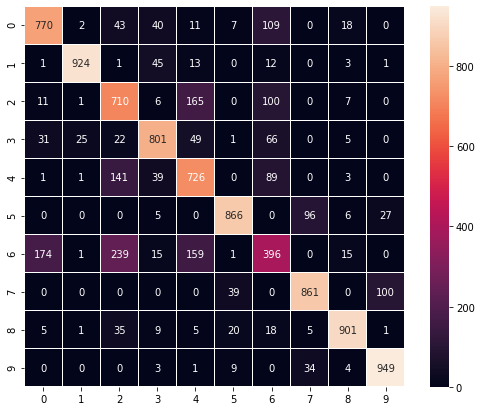

In [10]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
 
y_test = np.argmax(y_test, axis=1) 

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
#confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


In my first run, no data augmentation, 100 random samples of the Training Set, using 50% of that as the Validation Set, using a Batch Size of 50 and Epochs = 30, the resulting accuracy of the test-set is Test loss: 0.912209689617157
Test accuracy: 0.6866999864578247

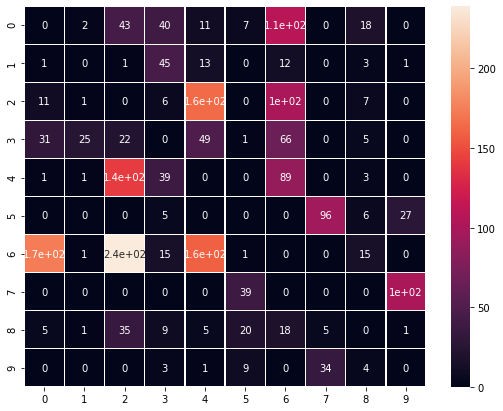

array([6, 3, 6, 1, 2, 7, 0, 5, 0, 7])

array([6, 3, 4, 6, 2, 7, 2, 9, 2, 7])

In [11]:
## I want to pick the largest value on the confusion matrix not on the diagonal
confusing_part_matrix= np.array(confusion_matrix)-np.identity(confusion_matrix.shape[0])*np.diag(confusion_matrix)

confusing_part_matrix = tf.convert_to_tensor(confusing_part_matrix)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusing_part_matrix,
    annot=True,
    linewidths=.5
    #,fmt="d"
    #,square=True
    #,ax=ax
)
plt.show()


## find the max value of those remaining numbers
thisnumber=np.max(confusing_part_matrix)

x_thisnumber=np.argmax(confusing_part_matrix,axis=0)
y_thisnumber=np.argmax(confusing_part_matrix,axis=1)
z_thisnumber=np.argmax(confusing_part_matrix)
display(x_thisnumber,y_thisnumber)
#print("The worst the algorithm did is between " confus)
 

In [ ]:

LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

delta = predictions - y_test

wrong = tf.boolean_mask(predictions, delta)
print(wrong)

#  if i != 0
#    display("Prediction ", i, " is " + LABEL_NAMES[predictions[i]], "but it is ",  LABEL_NAMES[y_test[i] )


In [12]:
confusing_part_matrix[0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=array([  0.,   2.,  43.,  40.,  11.,   7., 109.,   0.,  18.,   0.])>

In [13]:
z_thisnumber=np.argmax(confusing_part_matrix)
z_thisnumber
print("So the most confused classes were between: " , np.math.floor(z_thisnumber/10), " a",  LABEL_NAMES[np.math.floor(z_thisnumber/10)] , " and  ", z_thisnumber%10, " a ",  
LABEL_NAMES[z_thisnumber%10])



NameError: ignored

In [ ]:
plt.imshow(x_test[0].reshape((28,28)), cmap=plt.cm.binary)
plt.show()